In [1]:
import random
from tqdm.auto import trange
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.optim as optim

from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../..')

from src.rlmcmc.agent import Actor, QNetwork
from src.rlmcmc.env import RLMHEnvV31
from src.rlmcmc.utils import Args, Toolbox
from src.rlmcmc.learning import LearningDDPG

In [2]:
log_p = Toolbox.make_log_target_pdf(
    "test-banana-test-banana",
    "../../posteriordb/posterior_database"
)

In [3]:
# env setup
args = Args()
args.seed = 1234
args.log_target_pdf = log_p
args.total_timesteps = 10_000
args.batch_size = 32
args.learning_starts = args.batch_size
# args.learning_starts = 5_000
args.gamma = 0.5
# args.buffer_size = args.total_timesteps
args.learning_rate = 1e-5
args.policy_frequency = 2

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
predicted_envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

actor = Actor(envs).to(device)
actor = actor.double()
actor = torch.compile(actor)
qf1 = QNetwork(envs).to(device)
qf1 = qf1.double()
qf1 = torch.compile(qf1)
qf1_target = QNetwork(envs).to(device)
qf1_target = qf1_target.double()
qf1_target = torch.compile(qf1_target)
target_actor = Actor(envs).to(device)
target_actor = target_actor.double()
target_actor = torch.compile(target_actor)
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

envs.single_observation_space.dtype = np.float64
rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False
)

In [4]:
actor.load_state_dict(torch.load('save/model/ddpg.1705718428.550195.pth')['actor'])

<All keys matched successfully>

In [5]:
x = torch.linspace(-5., 5., 10, dtype=torch.float64).to(device)
y = torch.linspace(-2., 30., 10, dtype=torch.float64).to(device)

grid_x, grid_y = torch.meshgrid(x, y)

samples = torch.stack((grid_x.reshape(-1), grid_y.reshape(-1)), dim=1)
mcmc_noise_zero = torch.zeros((samples.shape[0], 2))
state = torch.cat((samples, mcmc_noise_zero), dim=1)
with torch.no_grad():
    cov = actor(state).detach().numpy()[:, 0:4].reshape(-1, 2, 2)

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392067780/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[2024-01-20 02:42:27,149] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_3
[2024-01-20 02:42:27,149] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_2
[2024-01-20 02:42:27,150] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_1
[2024-01-20 02:42:27,150] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

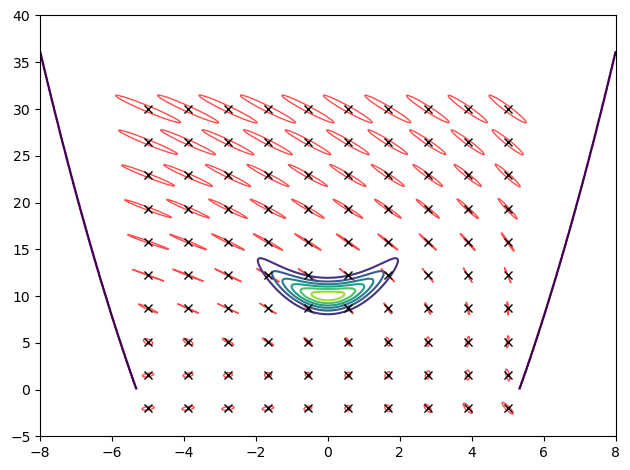

In [6]:
fig, ax = plt.subplots(1, 1)

num = 1000
x_target = np.linspace(-8., 8., num)
y_target = np.linspace(0., 40., num)
grid_x_target, grid_y_target = np.meshgrid(x_target, y_target)

pdf_res = np.zeros((num, num))

for i in trange(len(x_target)):
    for j in range(len(y_target)):
        pdf_res[i, j] = np.exp(log_p(np.array([x_target[i], y_target[j]])))

ax.contour(grid_x_target, grid_y_target, pdf_res.T)

samples_np = samples.detach().numpy()

for i in trange(samples.shape[0]):
    Toolbox.plot_action(samples[i], cov[i], 1.0, ax)
    ax.plot(samples_np[i][0], samples_np[i][1], 'kx')

ax.axis([-8., 8., -5., 40.])
# ax.set_aspect('equal')
plt.savefig('pic/normal.png', dpi=100)
plt.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

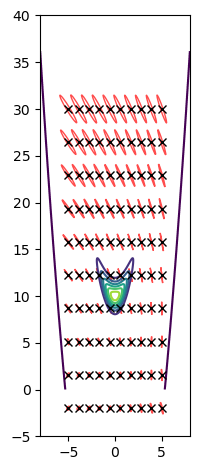

In [7]:
fig, ax = plt.subplots(1, 1)

num = 1000
x_target = np.linspace(-8., 8., num)
y_target = np.linspace(0., 40., num)
grid_x_target, grid_y_target = np.meshgrid(x_target, y_target)

pdf_res = np.zeros((num, num))

for i in trange(len(x_target)):
    for j in range(len(y_target)):
        pdf_res[i, j] = np.exp(log_p(np.array([x_target[i], y_target[j]])))

ax.contour(grid_x_target, grid_y_target, pdf_res.T)

samples_np = samples.detach().numpy()

for i in trange(samples.shape[0]):
    Toolbox.plot_action(samples[i], cov[i], 1.0, ax)
    ax.plot(samples_np[i][0], samples_np[i][1], 'kx')

ax.axis([-8., 8., -5., 40.])
ax.set_aspect('equal')
plt.savefig('pic/equal.png', dpi=100)
plt.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-01-20 02:42:48,584] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_3
[2024-01-20 02:42:48,585] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_2
[2024-01-20 02:42:48,585] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_1
[2024-01-20 02:42:48,585] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split


  0%|          | 0/12 [00:00<?, ?it/s]

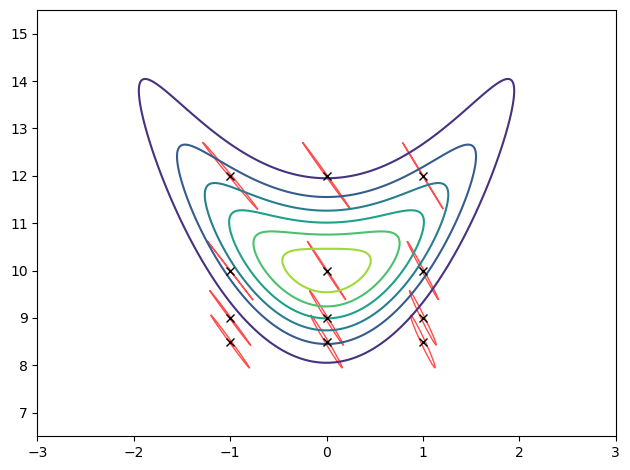

In [8]:
fig, ax = plt.subplots(1, 1)

# Target distribution
num = 1000
x_target = np.linspace(-5., 5., num)
y_target = np.linspace(5., 15., num)
grid_x_target, grid_y_target = np.meshgrid(x_target, y_target)

pdf_res = np.zeros((num, num))

for i in trange(len(x_target)):
    for j in range(len(y_target)):
        pdf_res[i, j] = np.exp(log_p(np.array([x_target[i], y_target[j]])))

ax.contour(grid_x_target, grid_y_target, pdf_res.T)

# Action distribution
# x = torch.linspace(-5., 5., 10, dtype=torch.float64).to(device)
# y = torch.linspace(5., 15., 10, dtype=torch.float64).to(device)

x = torch.tensor([-1., 0., 1.], dtype=torch.float64).to(device)
y = torch.tensor([8.5, 9., 10., 12.], dtype=torch.float64).to(device)

grid_x, grid_y = torch.meshgrid(x, y)

samples = torch.stack((grid_x.reshape(-1), grid_y.reshape(-1)), dim=1)
mcmc_noise_zero = torch.zeros((samples.shape[0], 2))
state = torch.cat((samples, mcmc_noise_zero), dim=1)
with torch.no_grad():
    cov = actor(state).detach().numpy()[:, 0:4].reshape(-1, 2, 2)

samples_np = samples.detach().numpy()

for i in trange(samples.shape[0]):
    Toolbox.plot_action(samples[i], cov[i], 1.0, ax)
    ax.plot(samples_np[i][0], samples_np[i][1], 'kx')

ax.axis([-3., 3., 6.5, 15.5])
# ax.set_aspect('equal')
plt.savefig('pic/select_normal.png', dpi=100)
plt.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

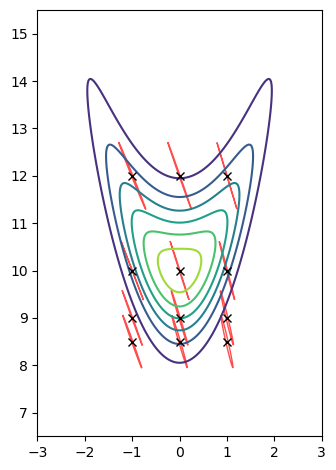

In [9]:
fig, ax = plt.subplots(1, 1)

# Target distribution
num = 1000
x_target = np.linspace(-5., 5., num)
y_target = np.linspace(5., 15., num)
grid_x_target, grid_y_target = np.meshgrid(x_target, y_target)

pdf_res = np.zeros((num, num))

for i in trange(len(x_target)):
    for j in range(len(y_target)):
        pdf_res[i, j] = np.exp(log_p(np.array([x_target[i], y_target[j]])))

ax.contour(grid_x_target, grid_y_target, pdf_res.T)

# Action distribution
# x = torch.linspace(-5., 5., 10, dtype=torch.float64).to(device)
# y = torch.linspace(5., 15., 10, dtype=torch.float64).to(device)

x = torch.tensor([-1., 0., 1.], dtype=torch.float64).to(device)
y = torch.tensor([8.5, 9., 10., 12.], dtype=torch.float64).to(device)

grid_x, grid_y = torch.meshgrid(x, y)

samples = torch.stack((grid_x.reshape(-1), grid_y.reshape(-1)), dim=1)
mcmc_noise_zero = torch.zeros((samples.shape[0], 2))
state = torch.cat((samples, mcmc_noise_zero), dim=1)
with torch.no_grad():
    cov = actor(state).detach().numpy()[:, 0:4].reshape(-1, 2, 2)

samples_np = samples.detach().numpy()

for i in trange(samples.shape[0]):
    Toolbox.plot_action(samples[i], cov[i], 1.0, ax)
    ax.plot(samples_np[i][0], samples_np[i][1], 'kx')

ax.axis([-3., 3., 6.5, 15.5])
ax.set_aspect('equal')
plt.savefig('pic/select_equal.png', dpi=100)
plt.tight_layout()